In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib nbagg
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
from pathlib import Path

import haiku as hk
os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/gpfslocalsys/cuda/10.1.2'
import jax
from jax.experimental import optix
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from nsec.normalization import SNParamsTree as CustomSNParamsTree
import pickle
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except IndexError:
    pass
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
from tqdm.notebook import tqdm

os.environ['SINGLECOIL_TRAIN_DIR'] = 'singlecoil_train/singlecoil_train/'
from tf_fastmri_data.datasets.cartesian import CartesianFastMRIDatasetBuilder
from tf_fastmri_data.datasets.noisy import ComplexNoisyFastMRIDatasetBuilder, NoisyFastMRIDatasetBuilder
from nsec.mri.fourier import FFT2
from nsec.mri.model import get_model
from nsec.samplers import ScoreHamiltonianMonteCarlo, ScoreMetropolisAdjustedLangevinAlgorithm

In [2]:
plt.rcParams['image.cmap'] = 'gray'

In [3]:
batch_size = 32
contrast = None
magnitude_images = True
common_kwargs = dict(
    brain=False,
    scale_factor=1e6,
    slice_random=True,
    contrast=contrast,
)
noise_kwargs = dict(
    noise_power_spec=30,
    noise_input=True,
    noise_mode='gaussian',
    residual_learning=True,
#     normal_noise_output=False,
    batch_size=batch_size,
    **common_kwargs,
)
if magnitude_images:
    ds_class = NoisyFastMRIDatasetBuilder
else:
    ds_class = ComplexNoisyFastMRIDatasetBuilder
    ds_kwargs.update(
        kspace_size=(320, 320),
    )
train_mri_ds = ds_class(
    dataset='train', 
    **noise_kwargs,
)
n_steps = 400
mri_images_iterator = train_mri_ds.preprocessed_ds.take(n_steps).as_numpy_iterator()

val_mri_ds = ds_class(
    dataset='val',
    **noise_kwargs
)
val_mri_images_iterator = val_mri_ds.preprocessed_ds.as_numpy_iterator()


val_mri_recon_ds = CartesianFastMRIDatasetBuilder(
    dataset='val',
    af=4,
    kspace_size=(320, 320),
    **common_kwargs,
)
val_mri_recon_iterator = val_mri_recon_ds.preprocessed_ds.as_numpy_iterator()
##### BATCH DEFINITION
# (image_noisy, noise_power), noise_realisation
# here the noise_realisation is the full one, not the epsilon from the standard normal law

In [4]:
model, loss_fn, update, params, state, sn_state, opt_state, rng_seq = get_model(
    magnitude_images=magnitude_images,
    pad_crop=False,
    sn_val=1.0,
)

/volatile/home/Zaccharie/workspace/score-estimation-comparison/venv/lib/python3.6/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [5]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cpu


In [6]:
#losses = []
# for step, batch in tqdm(enumerate(mri_images_iterator), total=n_steps):
#     loss, params, state, sn_state, opt_state = update(params, state, sn_state, next(rng_seq), opt_state, batch)
#     losses.append(loss)
#     if step%100==0:
#         print(step, loss)

In [7]:
# plt.figure()
# plt.loglog(losses[10:])

In [8]:
# Saving params

# with open('conv-dae-L2-mri-partial-training.pckl', 'wb') as file:
#     pickle.dump([params, state, sn_state], file)

In [9]:
# Importing saved model
with open('../conv-dae-L2-mri-30.0_mag_backup.pckl', 'rb') as file:
    params, state, sn_state = pickle.load(file)

In [10]:
from functools import partial
score = partial(model.apply, params, state, next(rng_seq))

In [11]:
(x, s), su = next(val_mri_images_iterator)
s = s[..., None, None, None]
res, state = score(x, s, is_training=False)

<IPython.core.display.Javascript object>


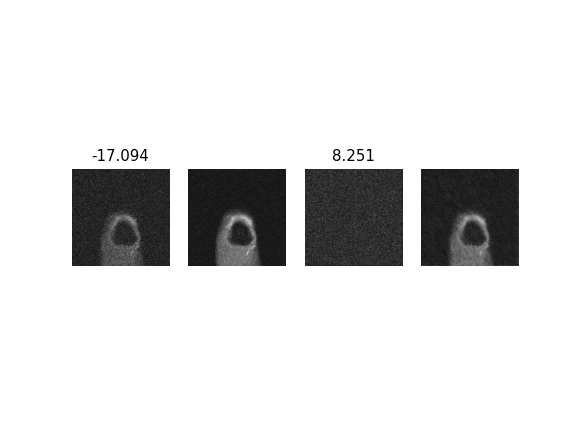

<IPython.core.display.Javascript object>


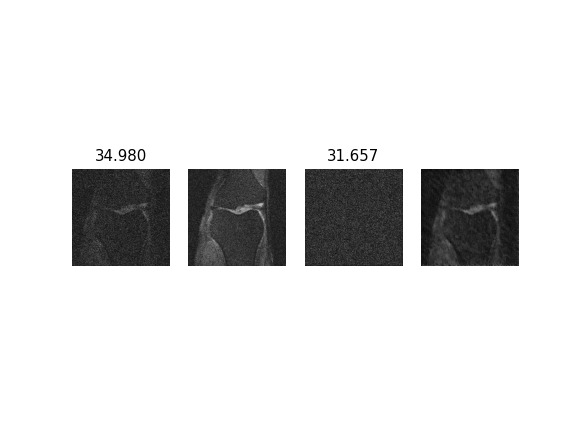

<IPython.core.display.Javascript object>


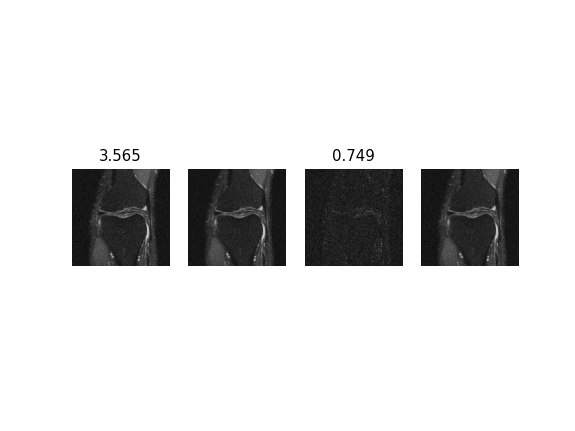

<IPython.core.display.Javascript object>


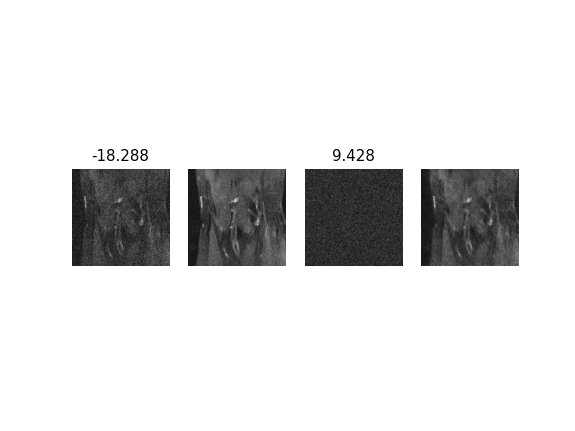

<IPython.core.display.Javascript object>


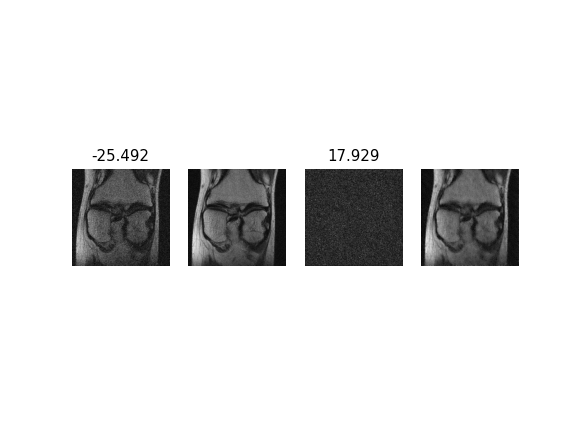

<IPython.core.display.Javascript object>


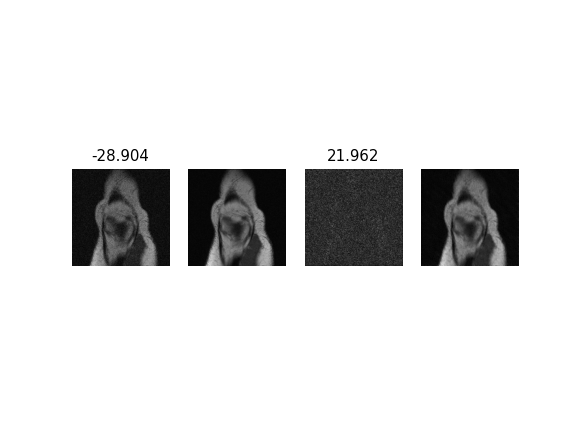

<IPython.core.display.Javascript object>


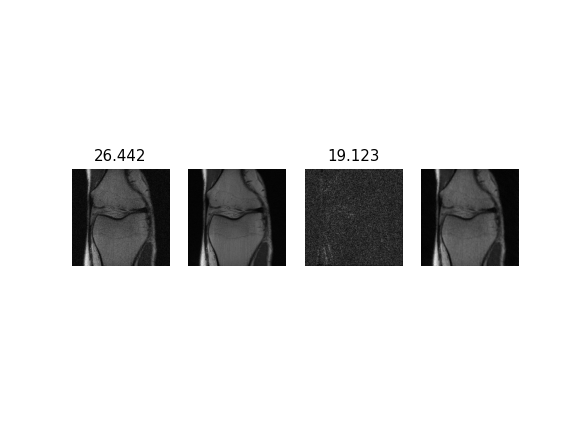

<IPython.core.display.Javascript object>


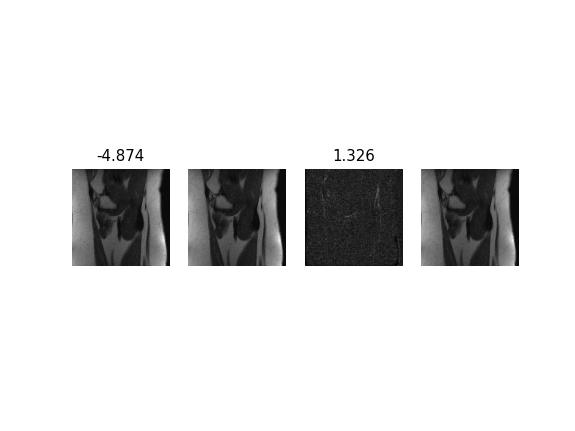

<IPython.core.display.Javascript object>


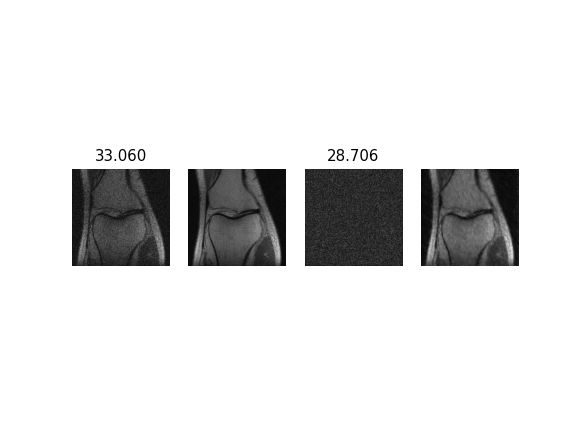

<IPython.core.display.Javascript object>


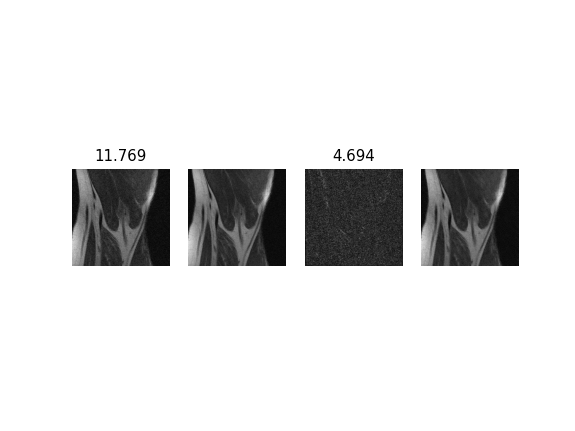

In [12]:
for i in range(10):
    ind = i
    fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
    axs[0].set_title("%0.3f"%s[ind,0,0,0])
    axs[0].imshow(jnp.abs(x)[ind,...,0],cmap='gray')
    axs[0].axis('off')
    axs[1].imshow(jnp.abs(x - su)[ind,...,0],cmap='gray')
    axs[1].axis('off')
    axs[2].imshow(jnp.abs(res)[ind,...,0],cmap='gray')
    axs[2].axis('off')
    axs[2].set_title("%0.3f"%jnp.std(s[ind,:,:,0]**2 *res[ind,...,0]))
    axs[3].imshow(jnp.abs(x[ind,...,0] + s[ind,:,:,0]**2 * res[ind,...,0]),cmap='gray')
    axs[3].axis('off')

In [13]:
# Trying to sample from the model

<IPython.core.display.Javascript object>


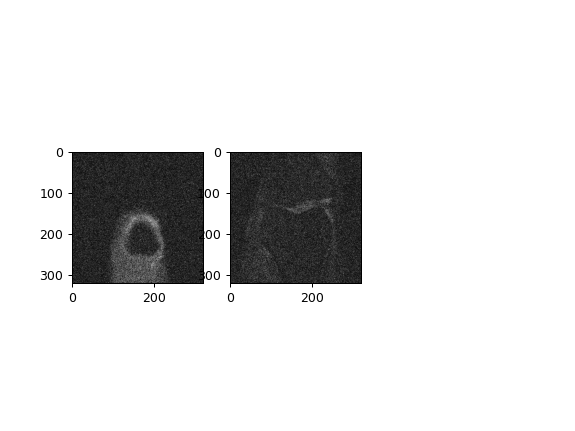

In [14]:
plt.figure()
plt.subplot(131)
plt.imshow(jnp.abs(x)[0,...,0].reshape((320,320,)))
plt.subplot(132)
plt.imshow(jnp.abs(x)[1,...,0].reshape((320,320,)))
# subplot(133)
# imshow(x[2,...,0].reshape((320,320,)))

In [15]:
# this is where I will need to add data consistency
l = 1e-1
temp = 6*1e1
def score_fn(x, y=None, mask=None, mode='prior', magnitude=False):
    """x is a float tensor, with imag and real concatenated in the channel axis
    """
    if y is None:
        w, h = 320, 320
    else:
        w, h = y.shape
    if magnitude:
        n_channels = 1
    else:
        n_channels = 2
    x_reshaped = x.reshape((1, w, h, n_channels))
    if not magnitude:
        x_reshaped = x_reshaped[..., 0] + 1j * x_reshaped[..., 1]
        x_reshaped = x_reshaped[..., None]

    prior = score(x_reshaped, jnp.zeros((1,1,1,1))+temp, is_training=False)[0]
    if mode == 'prior':
        out = prior
    elif mode == 'data_consistency':
        assert y is not None
        assert mask is not None
        fourier_obj = FFT2(mask)
        data_consistency = fourier_obj.adj_op(fourier_obj.op(x_reshaped[..., 0]) - y)
        data_consistency = data_consistency[..., None]
        out = prior + l * data_consistency
    if not magnitude:
        out_float = jnp.concatenate([out.real, out.imag], axis=-1)
    else:
        out_float = out
    out_reshaped = out_float.reshape((w*h*n_channels,))
    return out_reshaped

In [16]:
# first let's look at the prior

In [17]:
num_results = int(1e3)
num_burnin_steps = int(1e1)

In [18]:
step_size = 1e-0

@partial(jax.jit, static_argnums=(1, 2, 3, 4))
def get_samples(x, y=None, mask=None, mode='prior', magnitude=False):
    """x is a complex tensor
    """
    # First running SHMC
    kernel_shmc = ScoreHamiltonianMonteCarlo(
            target_score_fn=partial(score_fn, y=y, mask=mask, mode=mode, magnitude=magnitude),
            num_leapfrog_steps=4,
            num_delta_logp_steps=4,
            step_size=step_size,
    )
    if not magnitude:
        x_float = jnp.concatenate([x.real, x.imag], axis=-1)
    else:
        x_float = x
    samples_shmc, is_accepted_shmc = tfp.mcmc.sample_chain(
          num_results=num_results,
          num_burnin_steps=num_burnin_steps,
          current_state= x_float[0].reshape((jnp.prod(x_float[0].shape),)),
          kernel=kernel_shmc,
          trace_fn=lambda _, pkr: pkr.is_accepted, 
          seed=jax.random.PRNGKey(1),
    )
    return samples_shmc, is_accepted_shmc

In [19]:
%%time
samples_shmc, is_accepted_shmc = get_samples(x, None, None, 'prior', True)

/volatile/home/Zaccharie/workspace/score-estimation-comparison/venv/lib/python3.6/site-packages/jax/numpy/lax_numpy.py:1674: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


CPU times: user 10.9 s, sys: 322 ms, total: 11.2 s
Wall time: 11 s


In [20]:
%%time
samples_shmc = samples_shmc.block_until_ready()
is_accepted_shmc = is_accepted_shmc.block_until_ready()

CPU times: user 8h 31min 6s, sys: 3min 37s, total: 8h 34min 44s
Wall time: 19min 56s


In [21]:
len(jnp.where(is_accepted_shmc)[0])

983

In [22]:
samples_shmc = samples_shmc[jnp.where(is_accepted_shmc)[0]]

<IPython.core.display.Javascript object>


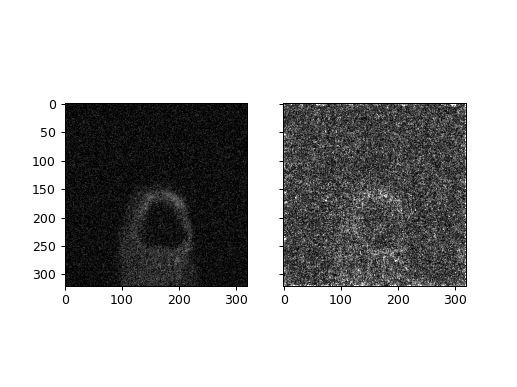

In [23]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
axs[0].imshow(jnp.linalg.norm(samples_shmc[0].reshape((320, -1, 1)), axis=-1), vmin=10, vmax=150)
axs[-1].imshow(jnp.linalg.norm(samples_shmc[-1].reshape((320, -1, 1)), axis=-1), vmin=10, vmax=150)

<IPython.core.display.Javascript object>


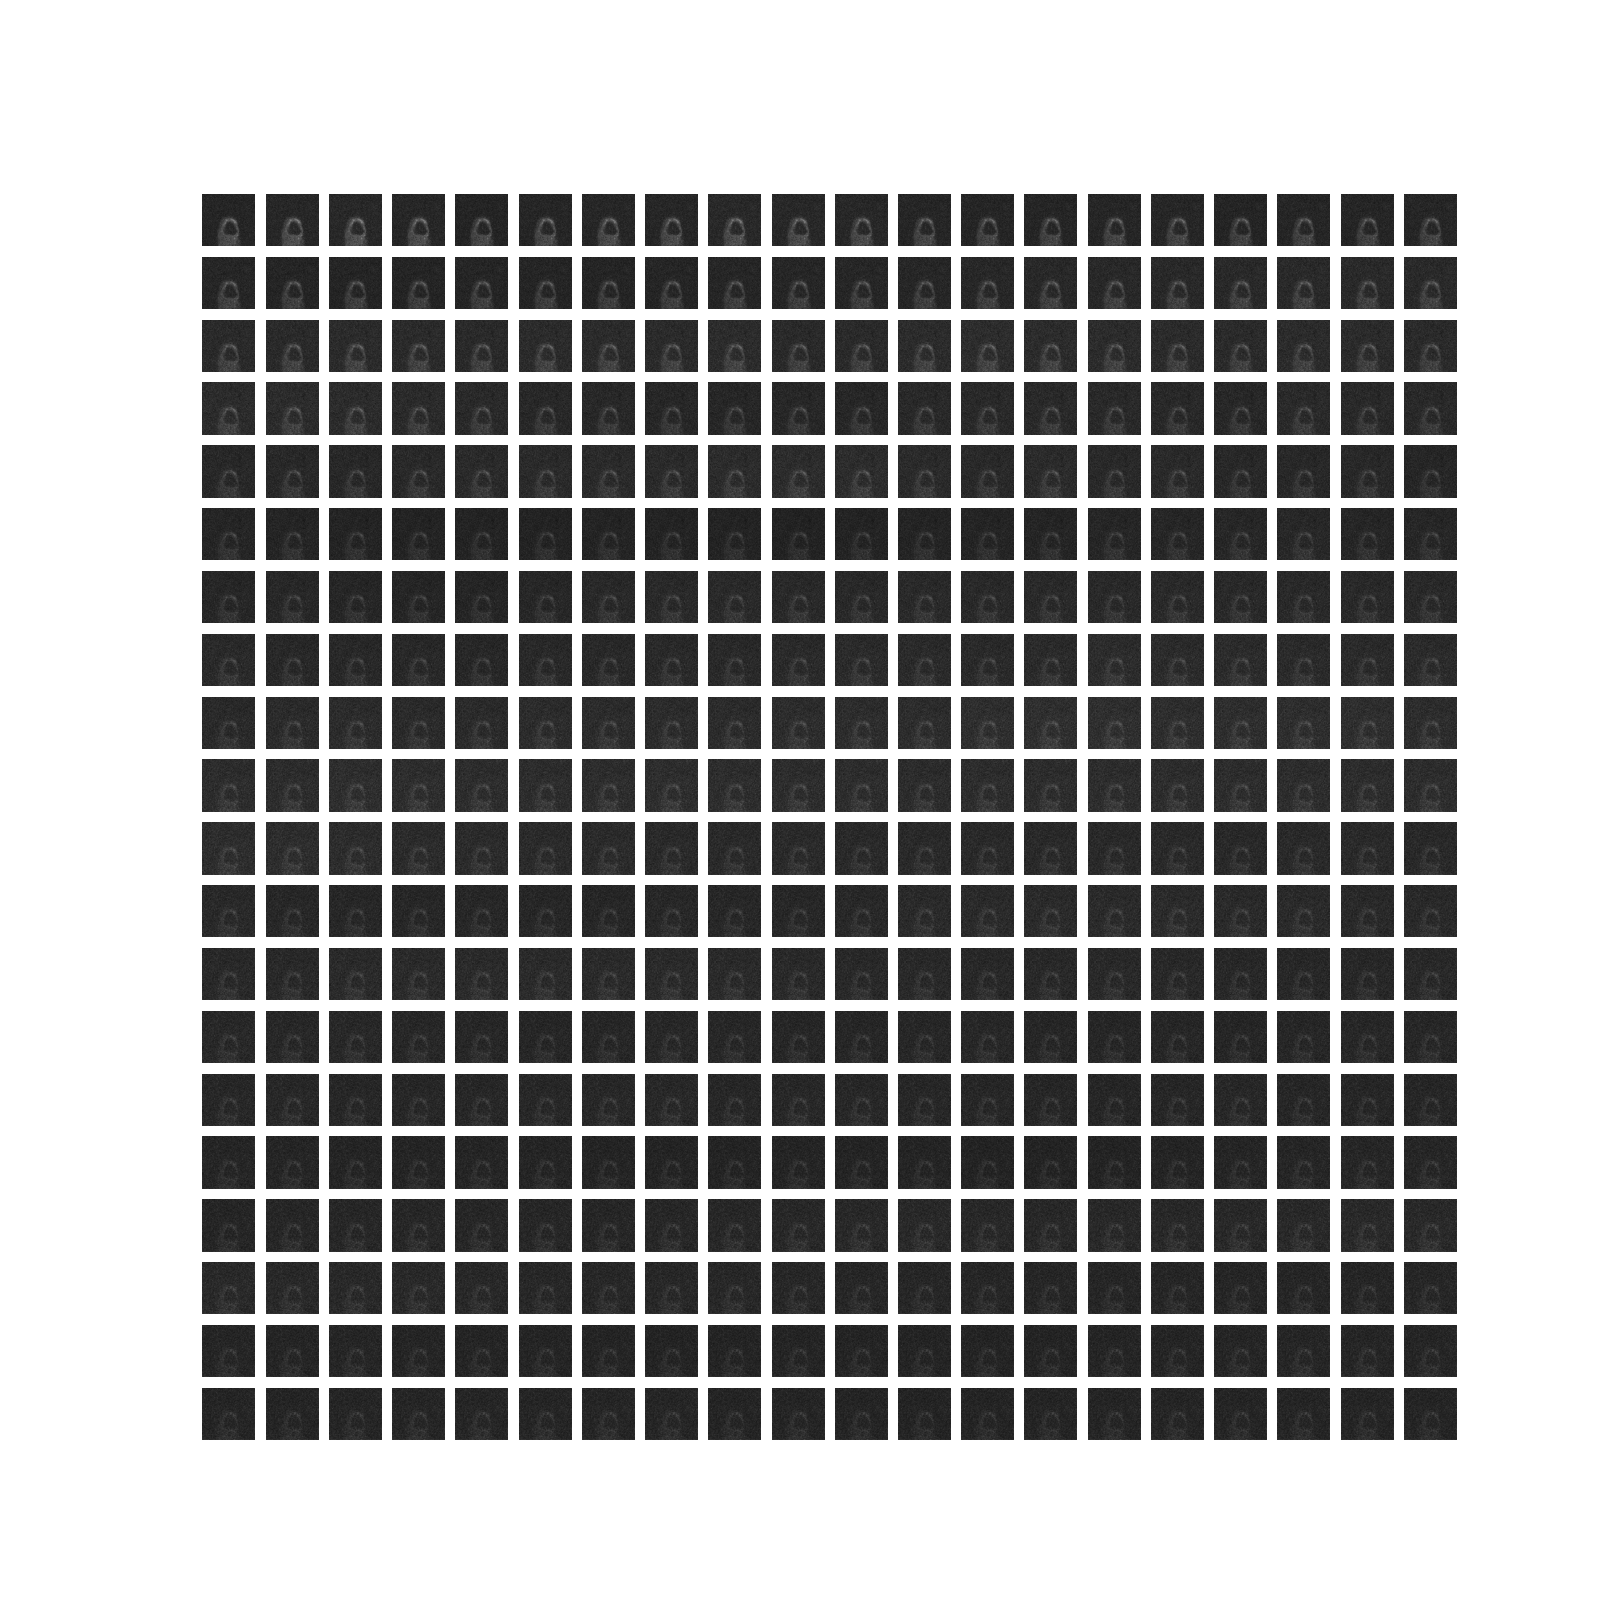

In [24]:
plt.figure(figsize=(20, 20))
for i in range(20):
  for j in range(20):
    plt.subplot(20,20,20*i+j+1)
    plt.imshow(jnp.linalg.norm(samples_shmc[(20*i+j)].reshape((320, -1, 1)), axis=-1))
    plt.axis('off')

<IPython.core.display.Javascript object>


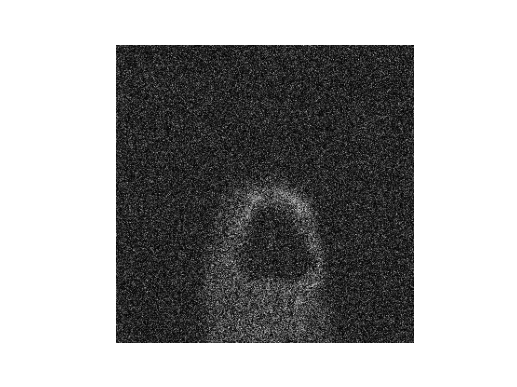

(-0.5, 319.5, 319.5, -0.5)

In [25]:
selected_ind = 10
plt.figure()
plt.imshow(jnp.linalg.norm(samples_shmc[selected_ind].reshape((320, -1, 1)), axis=-1))
plt.axis('off')

<IPython.core.display.Javascript object>


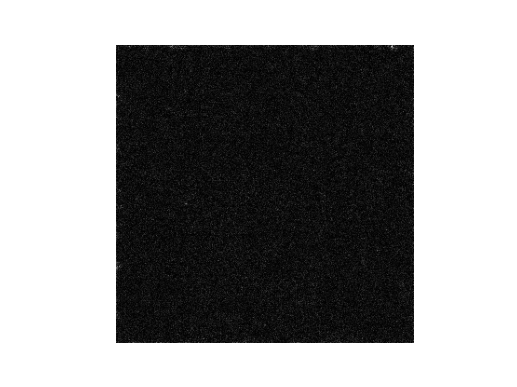

(-0.5, 319.5, 319.5, -0.5)

In [26]:
plt.figure()
plt.imshow(jnp.linalg.norm((samples_shmc[0] - samples_shmc[-1]).reshape((320, -1, 1)), axis=-1))
plt.axis('off')

In [27]:
# now let's look at the posterior

In [28]:
# (kspace, mask), image = next(val_mri_recon_iterator)
# fourier_obj = FFT2(jnp.tile(mask, [1, kspace.shape[1], 1]))
# x = fourier_obj.adj_op(kspace[..., 0])[..., None]

In [29]:
# %%time
# samples_shmc_post, is_accepted_shmc_post = get_samples(x, kspace[0, ..., 0], mask[0], 'data_consistency')

In [30]:
# %%time
# samples_shmc_post = samples_shmc_post.block_until_ready()
# is_accepted_shmc_post = is_accepted_shmc_post.block_until_ready()

In [31]:
# len(jnp.where(is_accepted_shmc_post)[0])

In [32]:
# samples_shmc_post = samples_shmc_post[jnp.where(is_accepted_shmc_post)[0]]

In [33]:
# fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)
# axs[0].imshow(jnp.abs(x[0]), vmin=30, vmax=100)
# axs[1].imshow(jnp.linalg.norm(samples_shmc_post[-1].reshape((320, -1, 2)), axis=-1), vmin=30, vmax=100)
# axs[2].imshow(image[0], vmin=30, vmax=100)

In [34]:
# n = 10
# fig, axs = plt.subplots(n, n, sharex=True, sharey=True, figsize=(20, 20))
# for i in range(n):
#   for j in range(n):
#     axs[i, j].imshow(jnp.linalg.norm(samples_shmc_post[10*(n*i + j)].reshape((320, -1, 2)), axis=-1), vmin=30, vmax=100, cmap='viridis')
#     axs[i, j].axis('off')